In [1]:
%reset -f
from pythonrc import *

In [2]:
def initialize_allocator(
    allocator_type: skadipy.allocator.AllocatorBase, **kwargs
) -> skadipy.allocator.AllocatorBase:
    return allocator_type(
        actuators=[
            tunnel,
            voithschneider_port,
            voithschneider_starboard,
        ],
        force_torque_components=[
            skadipy.allocator.ForceTorqueComponent.X,
            skadipy.allocator.ForceTorqueComponent.Y,
            skadipy.allocator.ForceTorqueComponent.N,
        ],
        **kwargs,
    )


time_step = 0.1
gamma = [1e-1, 1e-1, 1e-1]
mu = [1e-1, 1e-1, 1e-1]
rho = [1e1, 1e1, 1e1]
zeta = [1.0, 1.0, 1.0]
lambda_p = [0.99, 0.50, 0.0]


def initialize_allocators():
    a = []
    for i in range(3):
        a.append(
            initialize_allocator(
                skadipy.allocator.reference_filters.MinimumMagnitudeAndAzimuth,
                gamma=gamma[i],
                mu=mu[i],
                rho=rho[i],
                time_step=time_step,
                lambda_=lambda_p[i],
                zeta=zeta[i],
                control_barrier_function=skadipy.safety.ControlBarrierFunctionType.ABSOLUTE,
            )
        )
    return a

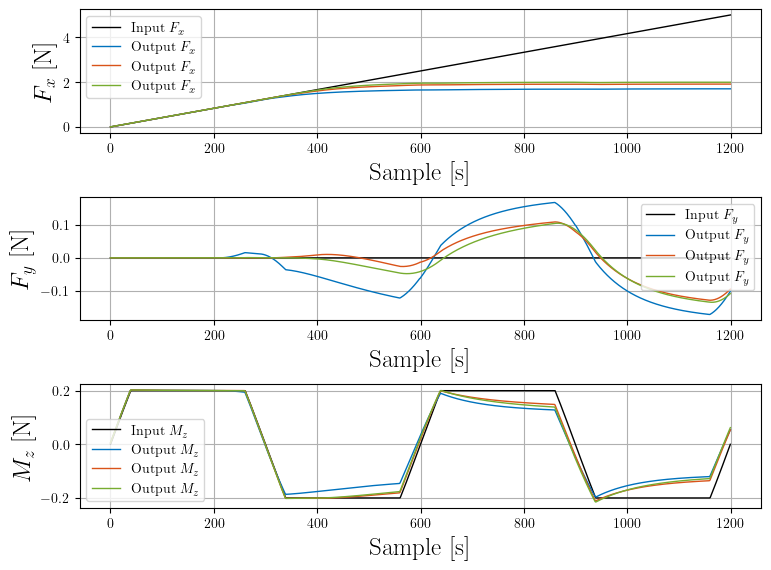

In [3]:
n = 1200
tau_cmd = np.zeros((n, 6))
tau_cmd[:,0] = np.linspace(0.0, 5.0, n)
tau_cmd[:,5] = gen_clipped_sin(n, 0.5, 2.0, 0.0, 0, -0.2, 0.2)

d_tau_cmd = np.gradient(tau_cmd, axis=0) / time_step

xi_hist, theta_hist, tau_hist = run_tests(tau_cmd=tau_cmd, d_tau_cmd=d_tau_cmd, allocators=initialize_allocators())
plot_histories(tau_cmd=tau_cmd, tau_alloc=tau_hist)


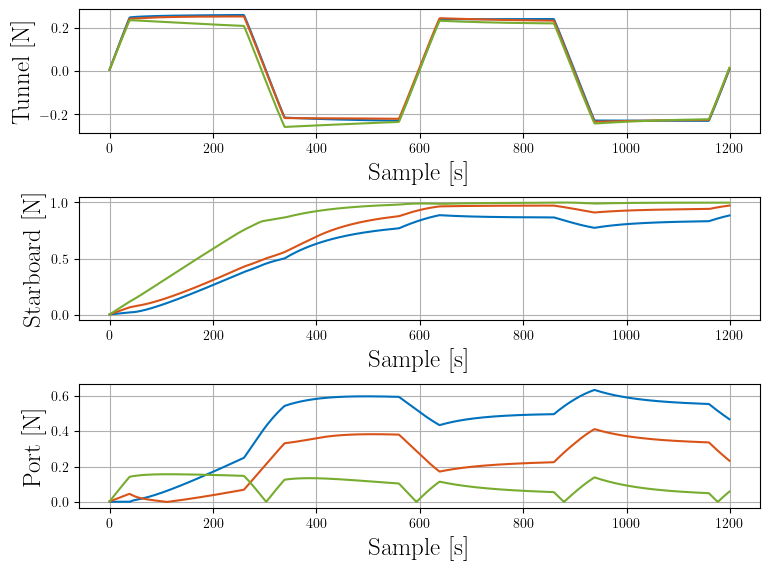

In [4]:
plot_thruster_forces(xi_hist)

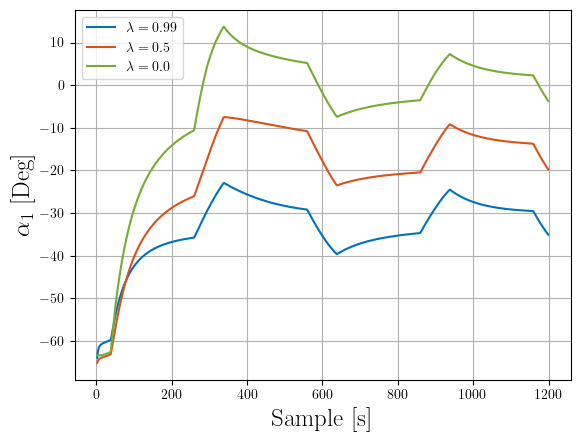

In [5]:
plot_angles(xi_hist)

l = []
for i in lambda_p:
    l.append(f"$\lambda = {i}$")

plt.legend(l)
# plt.plot(np.unwrap(angles[3][:,0]))
plt.grid(True)

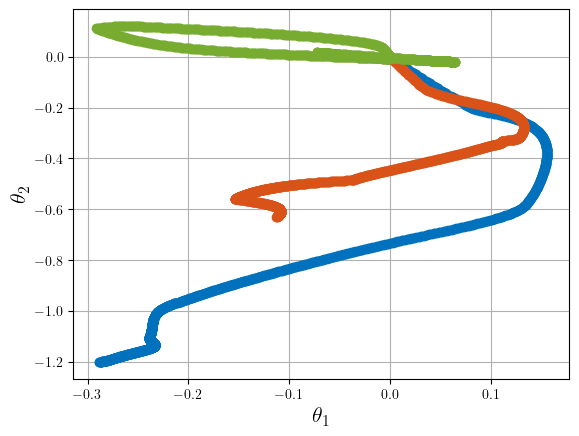

In [6]:
plot_theta_histories(theta_hist=theta_hist)

In [7]:
save_mat(
    filename="data/012.mat",
    inputs=tau_cmd,
    xi=xi_hist,
    thetas=theta_hist,
    outputs=tau_hist,
    zeta=zeta,
    rho=rho,
    gamma=gamma,
    mu=mu,
    lambda_p=lambda_p,
    thruster=voithschneider_port
)